In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (7.0, 4.0)
seaborn.mpl.rcParams['savefig.dpi'] = 100

import matplotlib
import matplotlib.pyplot as plt

def load_log_returns(file, field):
    data = pd.read_csv(file)
    prices = np.array(data[field])
    return np.diff(np.log(prices))

def load_returns(file, field):
    data = pd.read_csv(file)
    prices = np.array(data[field])
    return np.diff(prices) / prices[:-1]

log_returns = load_log_returns("data/SP500.csv", "Close")

train_returns = log_returns[0:1000]

sorted_train_returns = np.sort(train_returns)

### 1-2. Расчет VAR и ES историческим и параметрическим методами

#### Посчитаем исторические VAR и ES

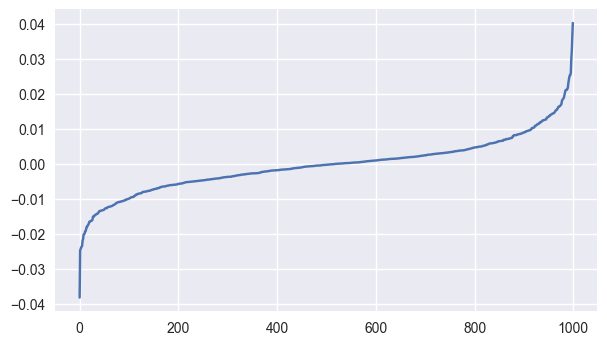

In [2]:
N = len(sorted_train_returns)
returns_plot = plt.plot(np.arange(N), sorted_train_returns)

Создадим функцию для расчета исторического VaR и редней просадки в случае пересечения уровня Var (Expected Shortfall):

1. Сортируем полученные в качестве аргумента доходности
2. Берем $\alpha$ самых малых доходностей, наибольшая из них и будет $VaR$
3. Усредняем значения доходностей меньшие уровня $VaR$, получаем $ES$

In [3]:
def history_var(data, alpha):
    sorted_data = np.sort(data)
    N = len(sorted_data)
    alphaN = round(N * alpha)
    return sorted_data[alphaN], np.mean(sorted_data[0:alphaN])

Используя реализованную функцию посчитаем $VaR$ для уровней 1% и 5% при условии, что весь капитал 1000000000

In [4]:
capital = 1000000000

var1, es1 = history_var(train_returns, 0.01)
var5, es5 = history_var(train_returns, 0.05)

print("Var(1) = %f, ES1 = %f" % ((var1 * capital), (es1 * capital)))
print("Var(5) = %f, ES5 = %f" % ((var5 * capital), (es5 * capital)))

Var(1) = -20080726.790476, ES1 = -24289235.531767
Var(5) = -13077359.109981, ES5 = -17287259.322200


#### Посчитаем параметрические VAR и ES

Оценим эмпирические первый и второй моменты для доходности.

$$\mu = \frac{1}{N} \sum_{i = 1}^{N} r_i$$

$$\sigma = \sqrt{\frac{1}{N} \sum_{i = 1}^{N} (r_i - \mu)^2}$$

Получаем значение процентной точки $ppf$ нормального распределения для заданного уровня $\alpha$.

Предполагая, что логарифмическая доходность распределена нормальна, можно найти значение процентной точки для этого распределения, это и будет $VaR$:

$$VaR = \mu - \left| ppf * \sigma \right|$$

Ожидаемая просадка может быть найдена как условное математическое ожидание просадки при условии, что потери больше уровня VaR. Оно может быть найденно по следующей формуле (из какой то статьи показывали на лекции):

$$ES = \frac{-\sigma * e^{-\frac{ppf}{2}}}{\alpha \sqrt{2\pi}}$$

In [5]:
from scipy.stats import norm

def parametric_var(data, alpha, period=1):
    mu = np.mean(data)
    sigma = np.sqrt(period) * np.std(data)
    ppf = norm.ppf(alpha)
    return mu - np.abs(ppf * sigma), (-sigma * np.exp(-np.power(ppf, 2) / 2) / (alpha * np.sqrt(2 * np.pi)))



Используя реализованную функцию посчитаем $VaR$ для уровней 1% и 5% при условии, что весь капитал 1000000000

In [6]:
var5, es5 = parametric_var(train_returns, 0.05)
var1, es1 = parametric_var(train_returns, 0.01)

print("Var(1) = %f, ES1 = %f" % ((var1 * capital), (es1 * capital)))
print("Var(5) = %f, ES5 = %f" % ((var5 * capital), (es5 * capital)))

Var(1) = -18884599.776851, ES1 = -21197395.613951
Var(5) = -13464433.902788, ES5 = -16405487.815920


Рассчитанные значения исторического и паарметрического значения для уровня 5% незначительно отличаются друг от друга. Тем временем значения 1% для модельного Var недооценивает реальную толщину левого хвоста распределения: значение модельного получается меньше реализованного. Примечательно, что Expected Shortfall также оказывается недооценен и для 5% уровня.

### 3. Расчет VAR с учетом ассиметрии и эксцесса

Процентная точка с учетом ассиметрии и эксцесса может быть найдена из разложения Корниша-Фишера:

$$\Omega(\alpha) = z(\alpha) + \frac{1}{6} (z(\alpha)^2 - 1) S + \frac{1}{24} (z(\alpha)^3 - 3 z(\alpha)) K - \frac{1}{36} (2 z(\alpha)^3 - 5 z(\alpha)) S^2$$

где S и K - эмпирические коэффициенты ассиметрии и эксцесса, соответственно. $z(\alpha)$ - процентная точка для стандартного нормального распределения.

$$VaR_{CF} = \mu + \Omega(\alpha) * \sigma$$

In [7]:
from scipy.stats import norm, kurtosis, skew

def cf_var(data, alpha, period=1):
    S = skew(data)
    K = kurtosis(data)
    mu = np.mean(data)
    sigma = np.std(data)
    z = norm.ppf(alpha)
    omega = z + 1/6 * (np.power(z, 2) - 1) * S + 1/24 * (np.power(z, 3) - 3 * z) * K - 1/36 * (2 * np.power(z, 3) - 5 * z) * np.power(S, 2)
    return (mu + omega * sigma)

Используя реализованную функцию посчитаем VaR с учетом ассиметрии и эксцесса для уровней 1% и 5% при условии, что весь капитал 1000000000

In [8]:
var1 = cf_var(train_returns, 0.01)
var5 = cf_var(train_returns, 0.05)

print("Var(1) = %f" % (var1 * capital))
print("Var(5) = %f" % (var5 * capital))

Var(1) = -20936537.559196
Var(5) = -12218414.023041


 ### 4. Расчет портфельного  VAR  для 1 дня, для уровней вероятности 0.05 и 0.01, для двух ковариационных матриц

Загрузим данные для следующих компаний: МТС, Сбербанк, Мечел, МосБиржа:

In [9]:
log_returns_moex = load_log_returns("data/MOEX_160616_170616.csv", "<CLOSE>")
log_returns_mtlr = load_log_returns("data/MTLR_160616_170616.csv", "<CLOSE>")
log_returns_mtss = load_log_returns("data/MTSS_160616_170616.csv", "<CLOSE>")
log_returns_sber = load_log_returns("data/SBER_160616_170616.csv", "<CLOSE>")

returns = np.stack([log_returns_moex, log_returns_mtlr, log_returns_mtss, log_returns_sber])

Пусть все бумаги в портфеле в равных долях. Посчитаем ковариационную матрицу для доходностей заданных активов. Пусть капитал 1000000 руб.

In [10]:
from scipy.stats import norm

capital = 1000000

alpha1 = 0.99
alpha5 = 0.95

weights = np.array([[0.25], [0.25], [0.25], [0.25]])

def portfolio_var(returns, weights, alpha, diagonal=False):
    ppf = norm.ppf(1 - alpha)
    cov_matrix = np.cov(returns)
    if diagonal:
        cov_matrix = cov_matrix * np.identity(cov_matrix.shape[0])
    marginal = cov_matrix.dot(weights)
    dispersion = marginal.T.dot(weights)
    sigma = np.sqrt(dispersion)
    return (capital * sigma * ppf)[0,0]

Посчитаем VaR с учетом диагональных элементов ковариационной матрицы

In [11]:
print("Var(1) = %f" % portfolio_var(returns, weights, 0.01))
print("Var(5) = %f" % portfolio_var(returns, weights, 0.05))

Var(1) = 33818.017143
Var(5) = 23911.165125


Посчитаем VaR без учета диагональных элементов ковариационной матрицы:

In [12]:
print("Var(1) = %f" % portfolio_var(returns, weights, 0.01, diagonal=True))
print("Var(5) = %f" % portfolio_var(returns, weights, 0.05, diagonal=True))

Var(1) = 27568.132420
Var(5) = 19492.158978


Вывод: без учета парных корреляций между инструментами в портфеле VaR получается меньше.

### 5. Бэк-тестинг однодневного VAR  (уровень вероятности 0.01) для четырех активов. Для процедуры взять  исторический,  параметрический и скорректированный VAR.

Оставлю тут ссылку на очень годную книженцию (стр 147)

https://www.scribd.com/doc/146088361/Value-at-Risk-3rd-Ed-the-New-Benchmark-for-Managing-Financial-Risk

Считаем все значения, которые будем тестировать и загрузим данные.

In [13]:
moex_history_var, _ = history_var(log_returns_moex, 0.01)
mtlr_history_var, _ = history_var(log_returns_mtlr, 0.01)
mtss_history_var, _ = history_var(log_returns_mtss, 0.01)
sber_history_var, _ = history_var(log_returns_sber, 0.01)

moex_parametric_var, _ = parametric_var(log_returns_moex, 0.01)
mtlr_parametric_var, _ = parametric_var(log_returns_mtlr, 0.01)
mtss_parametric_var, _ = parametric_var(log_returns_mtss, 0.01)
sber_parametric_var, _ = parametric_var(log_returns_sber, 0.01)

moex_cf_var = cf_var(log_returns_moex, 0.01)
mtlr_cf_var = cf_var(log_returns_mtlr, 0.01)
mtss_cf_var = cf_var(log_returns_mtss, 0.01)
sber_cf_var = cf_var(log_returns_sber, 0.01)

returns_moex = load_returns("data/MOEX_160616_170616.csv", "<CLOSE>")
returns_mtlr = load_returns("data/MTLR_160616_170616.csv", "<CLOSE>")
returns_mtss = load_returns("data/MTSS_160616_170616.csv", "<CLOSE>")
returns_sber = load_returns("data/SBER_160616_170616.csv", "<CLOSE>")

Напишем функцию для процедуры бэктестинга:

In [14]:
import scipy.stats

def backtest_var(returns, var, p):
    # размер периода
    T = returns.shape[0]
    # считаем число пересечений
    N = np.sum(returns < var)
    # считаем статистику
    LR = -2 * np.log(np.power(1 - p, T - N) * np.power(p, N)) + 2 * np.log(np.power(1 - N/T, T - N) * np.power(N/T, N))
    # сравниваем значение статистики с процентной точки хи-квадрат распределения    
    return ((LR < scipy.stats.chi2.ppf(1 - p, df=1)), LR, N)     

def backtest_report(method, instrument, returns, var, p):
    
    from colorama import Fore
    
    good_model, LR, N = backtest_var(returns, var, p)    
    if good_model:
        print(Fore.GREEN + "LR = %5.2f. N = %5.2f. Method %s for %s CAN BE applied with confidence %f." % 
              (LR, N, method, instrument, p))
    else:
        print(Fore.RED + "LR = %5.2f. N = %5.2f. Method %s for %s CAN NOT BE applied with confidence %f." % 
              (LR, N, method, instrument, p))

Проведем тесты для всех методов и инструментов:

In [15]:
backtest_report("historic_var", "MOEX", returns_moex, moex_history_var, 0.01)
backtest_report("historic_var", "MTLR", returns_mtlr, mtlr_history_var, 0.01)
backtest_report("historic_var", "MTSS", returns_mtss, mtss_history_var, 0.01)
backtest_report("historic_var", "SBER", returns_sber, sber_history_var, 0.01)

backtest_report("parametric_var", "MOEX", returns_moex, moex_parametric_var, 0.01)
backtest_report("parametric_var", "MTLR", returns_mtlr, moex_parametric_var, 0.01)
backtest_report("parametric_var", "MTSS", returns_mtss, moex_parametric_var, 0.01)
backtest_report("parametric_var", "SBER", returns_sber, moex_parametric_var, 0.01)

backtest_report("cf_var", "MOEX", returns_moex, moex_cf_var, 0.01)
backtest_report("cf_var", "MTLR", returns_mtlr, mtlr_cf_var, 0.01)
backtest_report("cf_var", "MTSS", returns_mtss, mtss_cf_var, 0.01)
backtest_report("cf_var", "SBER", returns_sber, sber_cf_var, 0.01)

LR =  0.08. N =  3.00. Method historic_var for MOEX CAN BE applied with confidence 0.010000.
LR =  0.08. N =  3.00. Method historic_var for MTLR CAN BE applied with confidence 0.010000.
LR =  0.08. N =  3.00. Method historic_var for MTSS CAN BE applied with confidence 0.010000.
LR =  0.08. N =  3.00. Method historic_var for SBER CAN BE applied with confidence 0.010000.
LR =  0.73. N =  4.00. Method parametric_var for MOEX CAN BE applied with confidence 0.010000.
LR = 15.68. N = 11.00. Method parametric_var for MTLR CAN NOT BE applied with confidence 0.010000.
LR =  0.73. N =  4.00. Method parametric_var for MTSS CAN BE applied with confidence 0.010000.
LR =  1.21. N =  1.00. Method parametric_var for SBER CAN BE applied with confidence 0.010000.
LR =  0.08. N =  3.00. Method cf_var for MOEX CAN BE applied with confidence 0.010000.
LR = 10.07. N =  9.00. Method cf_var for MTLR CAN NOT BE applied with confidence 0.010000.
LR =  1.21. N =  1.00. Method cf_var for MTSS CAN BE applied with 

### 6. Корреляционная матрица между активами и проверка на значимость парного коэффициента корреляции.

Загружаем доходности для рассматриваемых активов:

In [16]:
returns_moex = load_returns("data/MOEX_160616_170616.csv", "<CLOSE>")
returns_mtlr = load_returns("data/MTLR_160616_170616.csv", "<CLOSE>")
returns_mtss = load_returns("data/MTSS_160616_170616.csv", "<CLOSE>")
returns_sber = load_returns("data/SBER_160616_170616.csv", "<CLOSE>")

returns = np.stack([returns_moex, returns_mtlr, returns_mtss, returns_sber])

Заведем две матрицы, одну для самих коэффициентов, другую для p-value для тестирования гипотизы о значимости.

In [17]:
from scipy.stats import pearsonr

corr_matrix = np.identity(returns.shape[0])
p_values = np.zeros((returns.shape[0], returns.shape[0]))

for i in range(0, returns.shape[0]):
    for j in range(0, i + 1):
        temp = pearsonr(returns[i], returns[j])
        corr_matrix[i, j] = corr_matrix[j, i] = temp[0]
        p_values[i, j] = p_values[j, i] = temp[1]
        

Распечатаем корреляционную матрицу:

In [18]:
print(corr_matrix)

[[ 1.          0.08308285  0.2511714   0.40046729]
 [ 0.08308285  1.          0.11503544  0.2344532 ]
 [ 0.2511714   0.11503544  1.          0.36534841]
 [ 0.40046729  0.2344532   0.36534841  1.        ]]


Протестируем гипотизу на значимость коэффициентов корреляции при уровне значимости 5%

In [19]:
print(p_values < 0.05)

[[ True False  True  True]
 [False  True False  True]
 [ True False  True  True]
 [ True  True  True  True]]


Вывод: гипотиза о значимости коэффициента корреляции не может быть принята при 5% уровне значимости для пар (Мечел-Московская Биржа) и (Мечел-МТС)

### 7. Линейная парная регрессия для модели хеджирования.

In [20]:
returns_micex = load_returns("data/MICEXBMI.csv", "CLOSE")

Построим парные модели регрессий для выбранных инструменов и индекса.

In [21]:
from scipy.stats import linregress

def report_hedge(model):
    from colorama import Fore
    report = "Коэффициент хеджирования: %5.2f, значимость регрессии: p_value=%e" % (model[0], model[3])
    if model[3] > 0.05:
        print(Fore.RED + report)
    else:
        print(Fore.GREEN + report)

report_hedge(linregress(returns_moex,returns_micex))
report_hedge(linregress(returns_moex,returns_mtlr))
report_hedge(linregress(returns_moex,returns_mtss))
report_hedge(linregress(returns_moex,returns_sber))

Коэффициент хеджирования:  0.22, значимость регрессии: p_value=9.320559e-17
Коэффициент хеджирования:  0.17, значимость регрессии: p_value=1.877555e-01
Коэффициент хеджирования:  0.22, значимость регрессии: p_value=5.338288e-05
Коэффициент хеджирования:  0.33, значимость регрессии: p_value=3.658568e-11


### 8. Кредитный  VAR с использованием гауссовской копулы.

Когда то тут будет использование модели копулы для оценки кредитного VAR.